In [9]:
# wait-time curves and RNN prediction plots. Used in Fig 3, and Supp. Fig S2, S3, S5, S7

import torch
import sys
import os
import io
from os.path import exists
import numpy as np
import pickle
from scipy.special import softmax
import json

import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42


from dynamics.process.rnn import wt_kindergarten, wt_nets, wt_costs, wt_reinforce_cont_new, wt_pred, parse
from dynamics.vis import wt_vis
from dynamics.analysis import wt_analysis as wta
from dynamics.utils import utils


%load_ext autoreload
%autoreload 2
#%matplotlib notebook
#%matplotlib widget 
#out = widgets.Output(layout = widgets.Layout(height='300px'))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
# for figure 3
subdirlist = ['full_cl/', 'nok_cl/','nok_nocl/',
              'pkind_mem/', 'pkind_count/', 'pkind_int/', 'pkind_pred/',
             'wkind/','wokind/', 
              'nok_nocl_wreg/', 'nok_nocl_longsim/', 'pkind2_mem_inf/', 'gen_kind/','gen_kind_newreg/',
              'pkind3_mem_inf_count/','pkind3_mem_inf_int/', 'gen_kind_lowreg/','onehot/',
              'gen_kind_highreg/','genkind_indlosskind/','onehot_newreg/',
             'L50/', 'L100/','L500/','L1000/','L1000_mem100/',
             'inferencefirst/', 'shortinference/','nok_nocl_longsim/','gru/']

#index withint final trainign stage to grab data
kuse = [10,60,40,
        20,20,20,20,
        10,10, 
        40, 100, 40, 20, 20,
        40, 40, 20, 20, 
        0, 0, 0, 0, 0, 0, 0, 0,
       10, 10, 100, 
        10] 

# number of RNNs per training type, by sidx
num_rnns = {0:50, 1:50, 2:20, 3:20, 4:10, 5:10, 6:10, 7:10, 8:10, 9:10, 10:10, 11:20,
           12:10, 13:10, 14:20, 15:20, 16:10, 17:10,
           26:10, 27:10, 28:5, 29:50}  

klist_dict = {'3': [0,1,2], 's3':[0,3,4,5,6], '5':[0,7,8], 's3_pkind2': [0,3,6,11], 's3_wreg': [0,1,9],
               'pkind3': [0,11,14,15],'gen_kind':[0,1,8,9,13], 'onehot':[0,1,17], 'inf_manip': [0,26, 27],
             'longtrain':[0,28]}


In [10]:
dbase = '/Users/dhocker/projects/kind_cl/data/rnndata/'

/Users/dhocker/projects/kind_cl/data/rnndata/full_cl/33/rnn_curric_33_block_10.stats


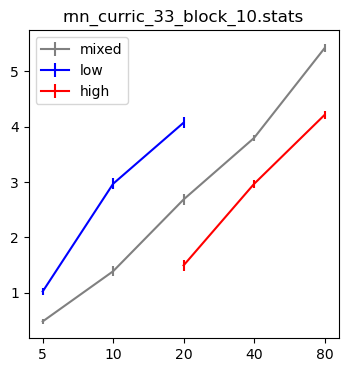

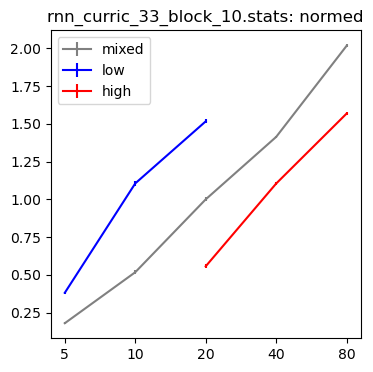

In [13]:
# a check of individual wt curve results. 

num = 33 # RNN number
s_idx = 0  # curriculum type. 0 = full_cl, 1 = shaping only (nok_cl), 2 = no cl (nok_nocl), 3 = memory CL (pkind_mem)
tphase = 5 # phase within training. 5 = block stage
idx = 10 # progress withint training stage. different for each sidx: (sidx=0) 10, (=1) 60, (=2) 40, (=3) 20

names = utils.getfnames(num, s_idx, tphase, idx, dbase=dbase)
fname_stats = names['stats']

isblockstage = True


#fname_stats = datadir+'rnn_curric_33_block_10.stats'


#option 1, load a .stats file. created by running wta.parsesimulation(dat, ops)
dat_stat = pickle.load(open(fname_stats,'rb'))
#pval,slope,adapt_20_ratio,nums, wtrange,b, wtdat, reg_histdat, reg_blockdat = parse.load_dat4stats(fname_stats)

#option 2, load a .json file and run wta.parsesimulation(dat, ops) on that. not shown here.


if isblockstage:

    fig, fig2 = wt_vis.plotblocks(dat_stat[0], name=fname_stats.split('/')[-1])

else :
    fig = wt_vis.plotsensitivity(dat_stat[0], idx=1, name=fname_stats.split('/')[-1])

#fig.savefig(savedir+str(num)+'_wt.pdf')

In [17]:
# plot the average wait time curve here
def plotblocks_allrnn(dict_list, idx=1, name='title', usenorm=False, alltraces=False):
    """
    plots sensitivity to reward, by blocks
    :param wt_dict: (dict) wait-time dicitionary from parsesimulation()
    :param idx: (int) id for output figure
    :param name: (str) plot title
    :param usenorm: (bool) normalize wait times to 20ul in mixed?
    :return:
    """
    
    #extract mixed, low, and high means
    if usenorm:
        wt_means_mixed = np.array([k['wt_mixed']/k['wt_mixed'][2] for k in dict_list])
        wt_means_high = np.array([k['wt_high']/k['wt_mixed'][2] for k in dict_list])
        wt_means_low = np.array([k['wt_low']/k['wt_mixed'][2] for k in dict_list])
    else:
        wt_means_mixed = np.array([k['wt_mixed'] for k in dict_list])
        wt_means_high = np.array([k['wt_high'] for k in dict_list])
        wt_means_low = np.array([k['wt_low'] for k in dict_list])

    
    wt_mixed = np.nanmean(wt_means_mixed,axis=0)
    wt_high = np.nanmean(wt_means_high,axis=0)
    wt_low = np.nanmean(wt_means_low,axis=0)
    
    wt_mixed_sem = np.nanstd(wt_means_mixed,axis=0)/np.sqrt(len(dict_list))
    wt_high_sem = np.nanstd(wt_means_high,axis=0)/np.sqrt(len(dict_list))
    wt_low_sem = np.nanstd(wt_means_low,axis=0)/np.sqrt(len(dict_list))
    
    print(wt_means_mixed.shape)
    #print(wt_means_high)
    #print(wt_means_low)
    
    
    Vvec = np.array([5, 10, 20, 40, 80])
    fig = plt.figure(idx, figsize=(4, 4))
    # plt.errorbar(np.log2(Vvec),wt_dict['wt'],wt_dict['wt_sem'],label='all')
    plt.errorbar(np.log2(Vvec), wt_mixed, wt_mixed_sem, label='mixed', color='gray')
    plt.errorbar(np.log2(Vvec), wt_low, wt_low_sem, label='low', color='blue')
    plt.errorbar(np.log2(Vvec), wt_high, wt_high_sem, label='high', color='red')
    
    if alltraces:
        for j in range(len(wt_means_mixed)):
            plt.plot(np.log2(Vvec), wt_means_mixed[j], color='gray',linewidth=0.25)
            plt.plot(np.log2(Vvec), wt_means_low[j], color='blue',linewidth=0.25)
            plt.plot(np.log2(Vvec),wt_means_high[j], color='red',linewidth=0.25)
            
    plt.xticks(np.log2(Vvec))
    plt.gca().set_xticklabels(Vvec)
    plt.legend()
    plt.title('all rnn:'+name)
    #if 'p_signrank' in wt_dict:
    #    text2plot = 'sign-rank p: {:.2e} \n ranksum p: {:.2e}'.format(wt_dict['p_signrank'], wt_dict['p_ranksum'])
    #    plt.annotate(text2plot, (0.7, 0.7), xytext=(0.7, 0.7), textcoords='axes fraction')
    plt.show()

   

    return fig

skipping:45
(49, 5)


/var/folders/c4/ykbrg7ls1_bbwq7_pwvytxjh0000gn/T/ipykernel_25059/3115887248.py:24: RuntimeWarning: Mean of empty slice
  wt_high = np.nanmean(wt_means_high,axis=0)
/var/folders/c4/ykbrg7ls1_bbwq7_pwvytxjh0000gn/T/ipykernel_25059/3115887248.py:25: RuntimeWarning: Mean of empty slice
  wt_low = np.nanmean(wt_means_low,axis=0)


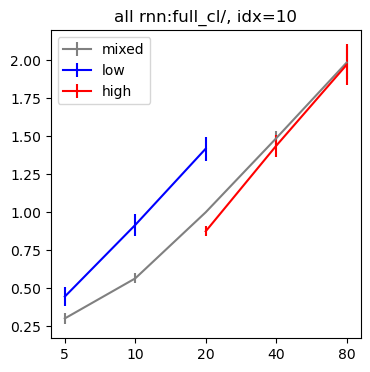

skipping:21
skipping:29
skipping:41
(47, 5)


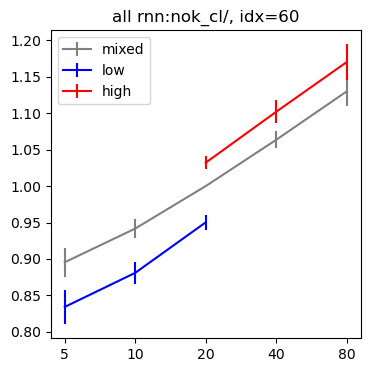

/Users/dhocker/projects/kind_cl/data/rnndata/nok_nocl/1/rnn_curric_1_block_40_1k.stats
/Users/dhocker/projects/kind_cl/data/rnndata/nok_nocl/2/rnn_curric_2_block_40_1k.stats
skipping:2
/Users/dhocker/projects/kind_cl/data/rnndata/nok_nocl/3/rnn_curric_3_block_40_1k.stats
/Users/dhocker/projects/kind_cl/data/rnndata/nok_nocl/4/rnn_curric_4_block_40_1k.stats
/Users/dhocker/projects/kind_cl/data/rnndata/nok_nocl/5/rnn_curric_5_block_40_1k.stats
/Users/dhocker/projects/kind_cl/data/rnndata/nok_nocl/6/rnn_curric_6_block_40_1k.stats
skipping:6
/Users/dhocker/projects/kind_cl/data/rnndata/nok_nocl/7/rnn_curric_7_block_40_1k.stats
/Users/dhocker/projects/kind_cl/data/rnndata/nok_nocl/8/rnn_curric_8_block_40_1k.stats
/Users/dhocker/projects/kind_cl/data/rnndata/nok_nocl/9/rnn_curric_9_block_40_1k.stats
/Users/dhocker/projects/kind_cl/data/rnndata/nok_nocl/10/rnn_curric_10_block_40_1k.stats
/Users/dhocker/projects/kind_cl/data/rnndata/nok_nocl/11/rnn_curric_11_block_40_1k.stats
/Users/dhocker/pr

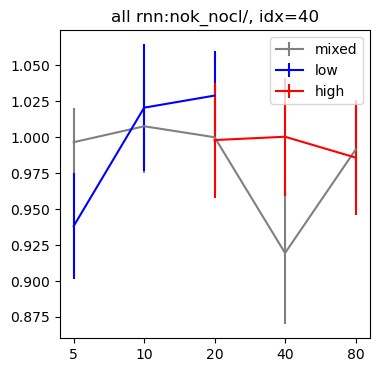

In [26]:
# 0,1,2,3,4,5,6,9,11,12,13,14,15,17
# the rnn-averaged wait time curves, normalized to 20ul in mixed

klist = klist_dict['3']

for s_idx in klist:
    t_idx = 5
    idx = kuse[s_idx]
    
    dict_list = []

    for j in range(1,num_rnns[s_idx]+1):
    #for j in range(1,11):
        names = utils.getfnames(j, s_idx, tphase, idx, dbase=dbase)
        if s_idx == 2:
            
            fname_stats = names['stats']
            print(fname_stats)
            
            #fname_stats = fname_funs[t_idx](j,idx, s_idx)+'_1k.stats'          
            
        else:
            #fname_stats = fname_funs[t_idx](j,idx, s_idx)+'.stats'
            fname_stats = names['stats']

        try:
            a = pickle.load(open(fname_stats,'rb'))
            dict_list.append(a[0])
        except:
            print('skipping:'+str(j))


    #a[0]
    if s_idx == 0:
        fig = plotblocks_allrnn(dict_list, idx=1, name=subdirlist[s_idx]+', idx='+str(idx), usenorm=True, alltraces=False)
    else:
        fig = plotblocks_allrnn(dict_list, idx=1, name=subdirlist[s_idx]+', idx='+str(idx), usenorm=True, alltraces=False)
    #fig.savefig(savedir+'allRNN_s'+str(s_idx)+'idx_'+str(idx)+'_wt.pdf')
    plt.show()